## Portfolio Optimization

In [22]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [23]:
import yfinance as yf
quotes = yf.download("SPY GLD VWO BABA BIDU WMT TIP PG BMY TMF", start="2017-01-01", end="2017-04-30")
data= quotes['Adj Close']

[*********************100%***********************]  10 of 10 completed


,BABA,BIDU,BMY,GLD,PG,SPY,TIP,TMF,VWO,WMT
Date,,,,,,,,,,
2017-01-03,88.599998,168.300003,52.033493,110.470001,73.938202,208.213501,104.197304,16.990763,32.456806,62.520519
2017-01-04,90.510002,171.960007,52.103985,110.860001,74.201645,209.452240,104.427246,17.204659,32.752918,62.884735
2017-01-05,94.370003,177.470001,52.976208,112.580002,74.693390,209.285812,104.785995,18.004440,33.093914,63.021332
2017-01-06,93.889999,176.380005,52.817612,111.750000,74.667046,210.034561,104.353653,17.474354,32.959316,62.156273
2017-01-09,94.720001,177.160004,52.623791,112.669998,74.113846,209.341278,104.519234,17.930042,32.905468,62.566029
...,...,...,...,...,...,...,...,...,...,...
2017-04-24,114.860001,180.029999,47.521362,121.480003,79.866302,220.195480,105.637070,18.469435,36.101330,68.593948
2017-04-25,115.480003,186.990005,47.867455,120.250000,80.267639,221.476685,105.462090,17.809147,36.362026,68.841621
2017-04-26,114.970001,186.669998,47.716595,120.839996,78.252029,221.337448,105.683136,18.088139,36.227184,69.190170


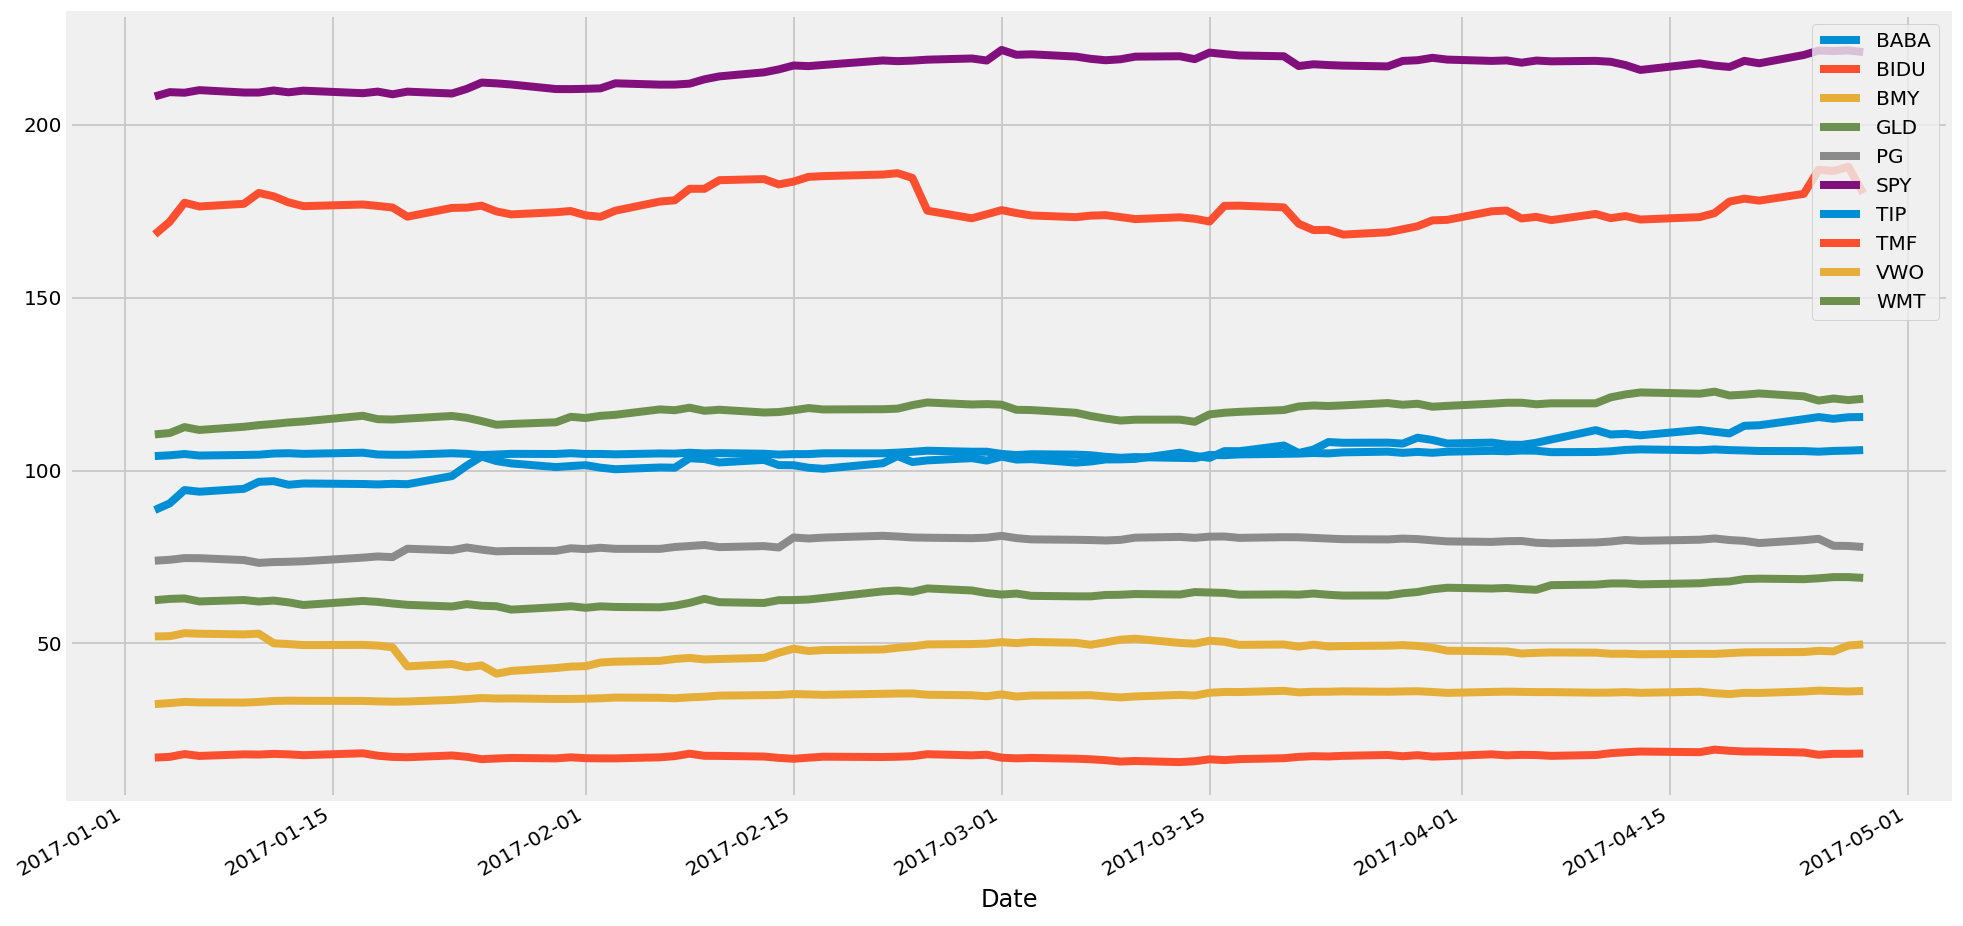

In [24]:
data.plot(figsize=(15,8))
data

Text(0, 0.5, 'price in $')

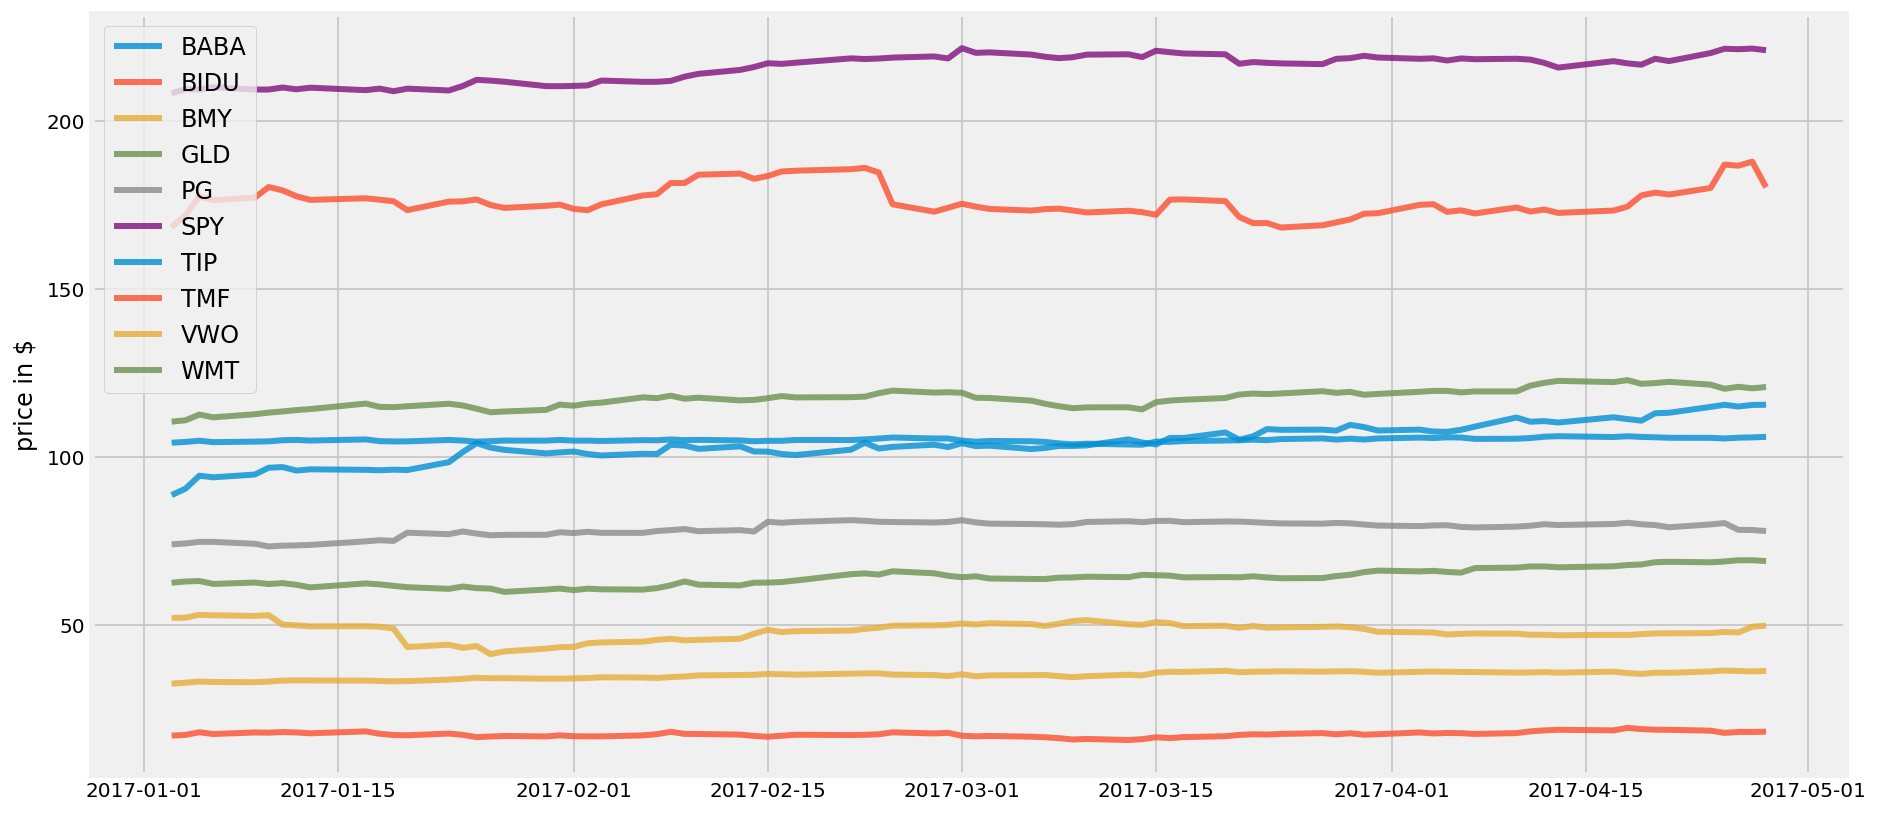

In [25]:
table = data

plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

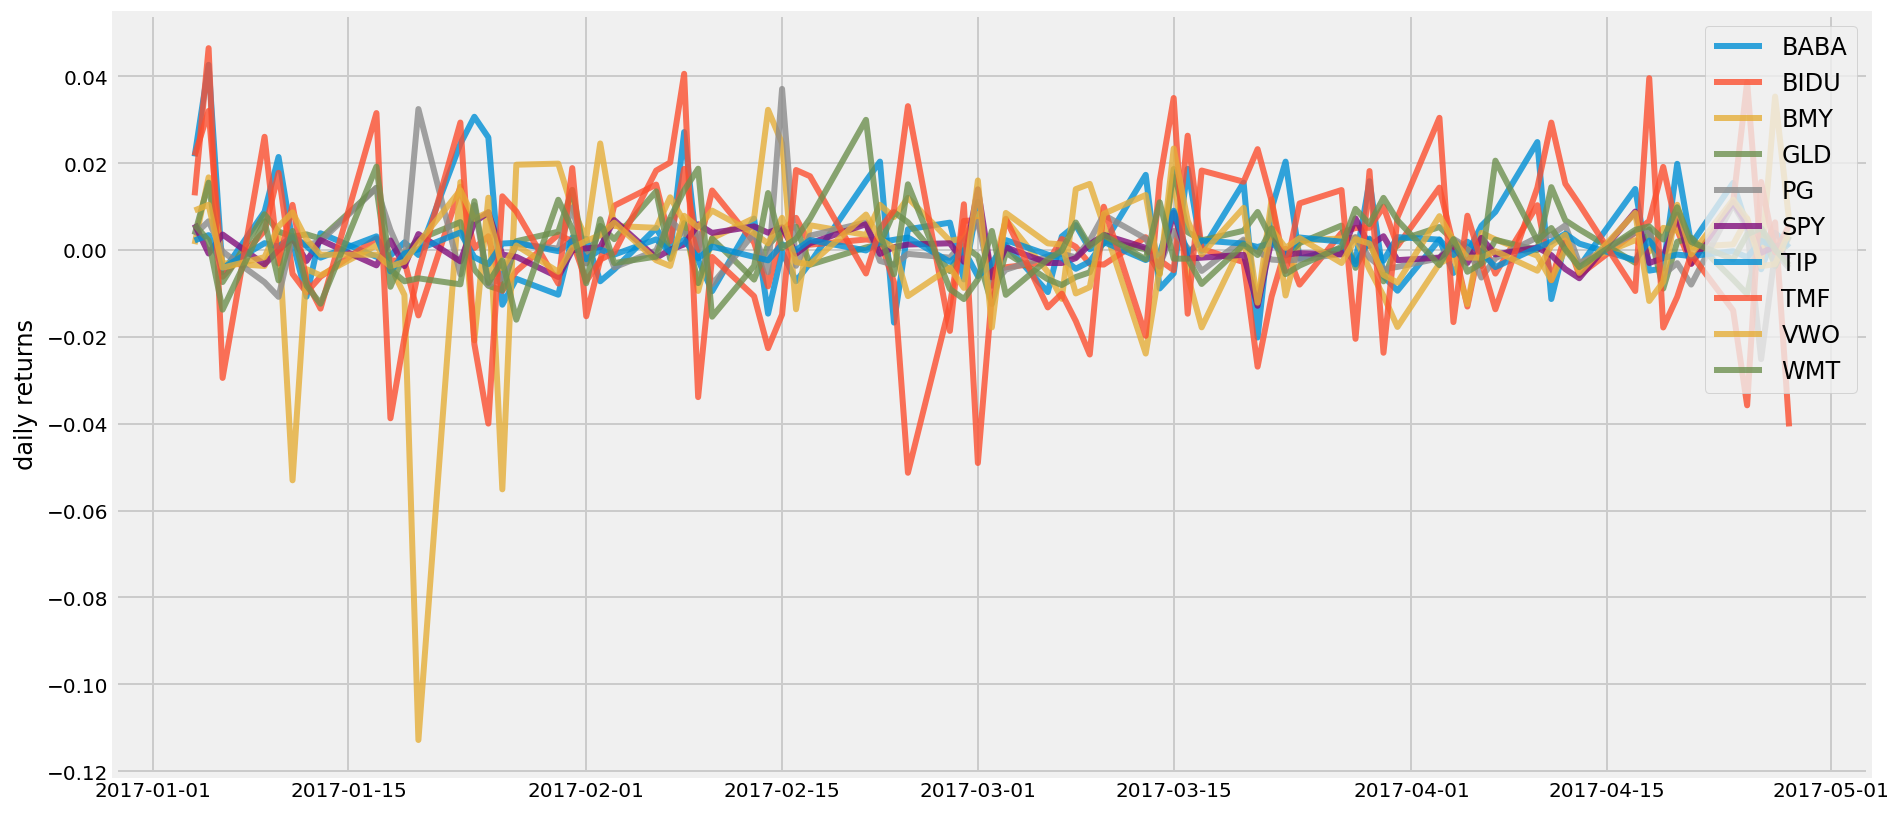

In [26]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

<AxesSubplot:xlabel='Date'>

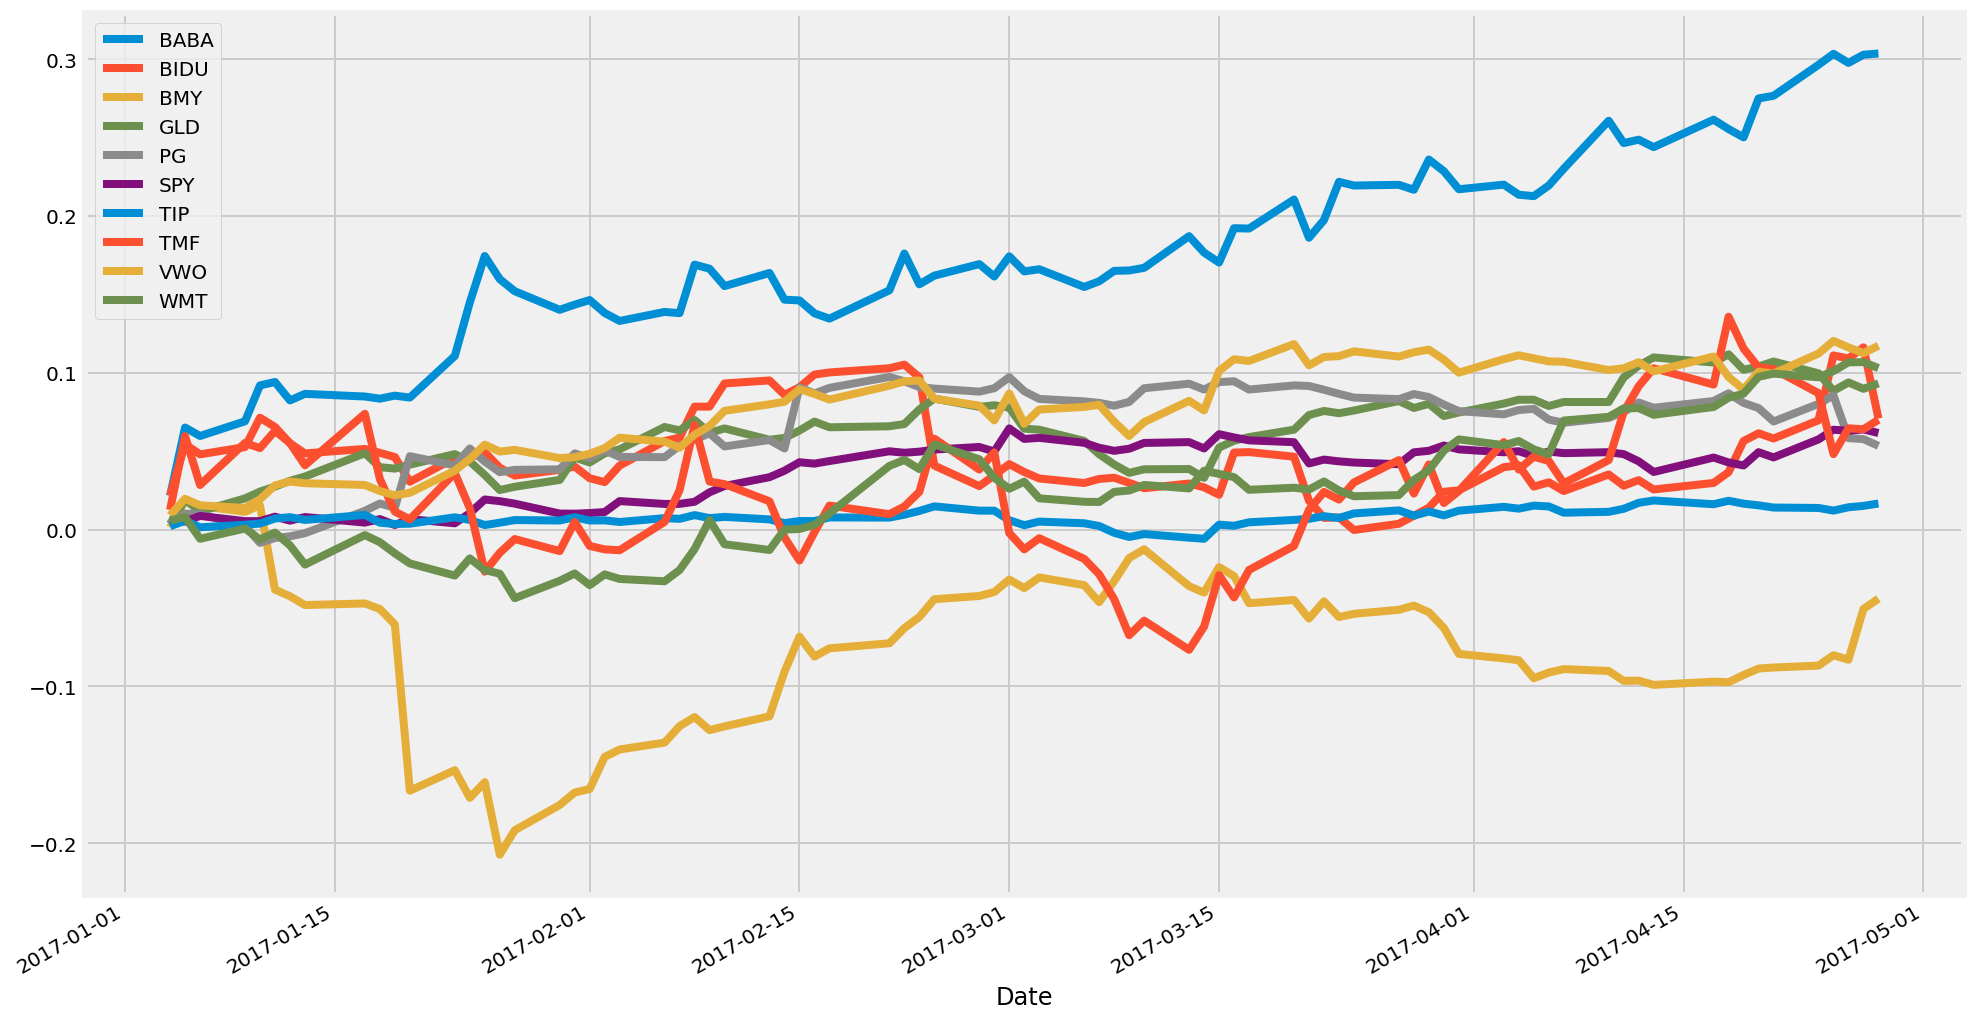

In [27]:
#Total return
((returns + 1).cumprod() - 1).plot(figsize=(15,9))


In [32]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(data.columns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [33]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [34]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.33
Annualised Volatility: 0.06


             BABA  BIDU   BMY    GLD    PG    SPY    TIP   TMF   VWO    WMT
allocation  17.65  0.36  1.58  16.76  6.77  23.46  12.67  1.41  9.17  10.16
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.05


            BABA  BIDU   BMY   GLD    PG    SPY    TIP   TMF   VWO    WMT
allocation  2.91  7.79  3.57  7.85  6.83  23.19  23.39  2.46  9.96  12.06


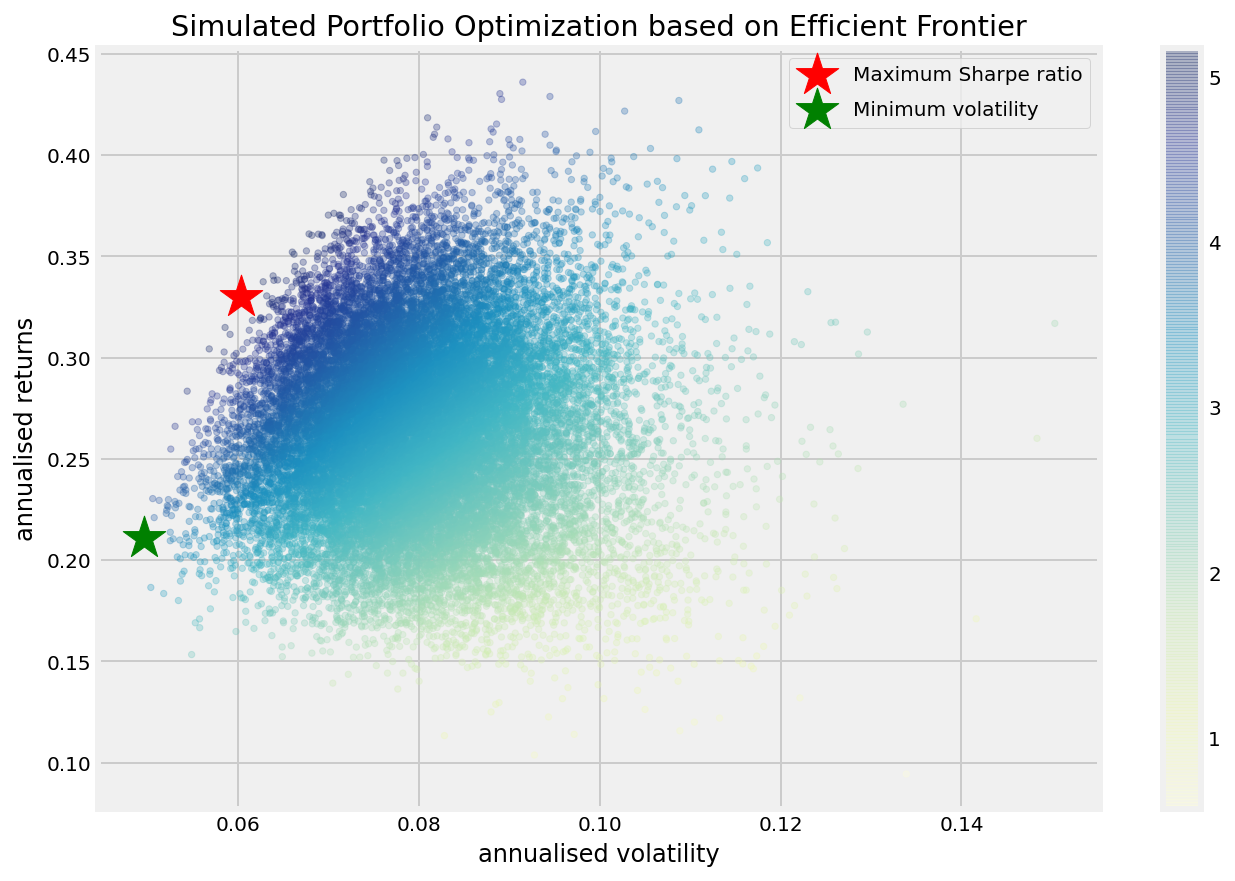

In [35]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [38]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)- 1})


In [39]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [43]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.38
Annualised Volatility: 0.06


             BABA  BIDU  BMY    GLD   PG    SPY  TIP  TMF  VWO    WMT
allocation  21.44   0.0  0.0  32.72  0.0  32.37  0.0  0.0  0.0  13.47
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.03


            BABA  BIDU   BMY  GLD   PG    SPY    TIP  TMF  VWO   WMT
allocation   0.0  0.69  0.16  0.0  0.0  26.88  68.25  0.0  0.0  4.02


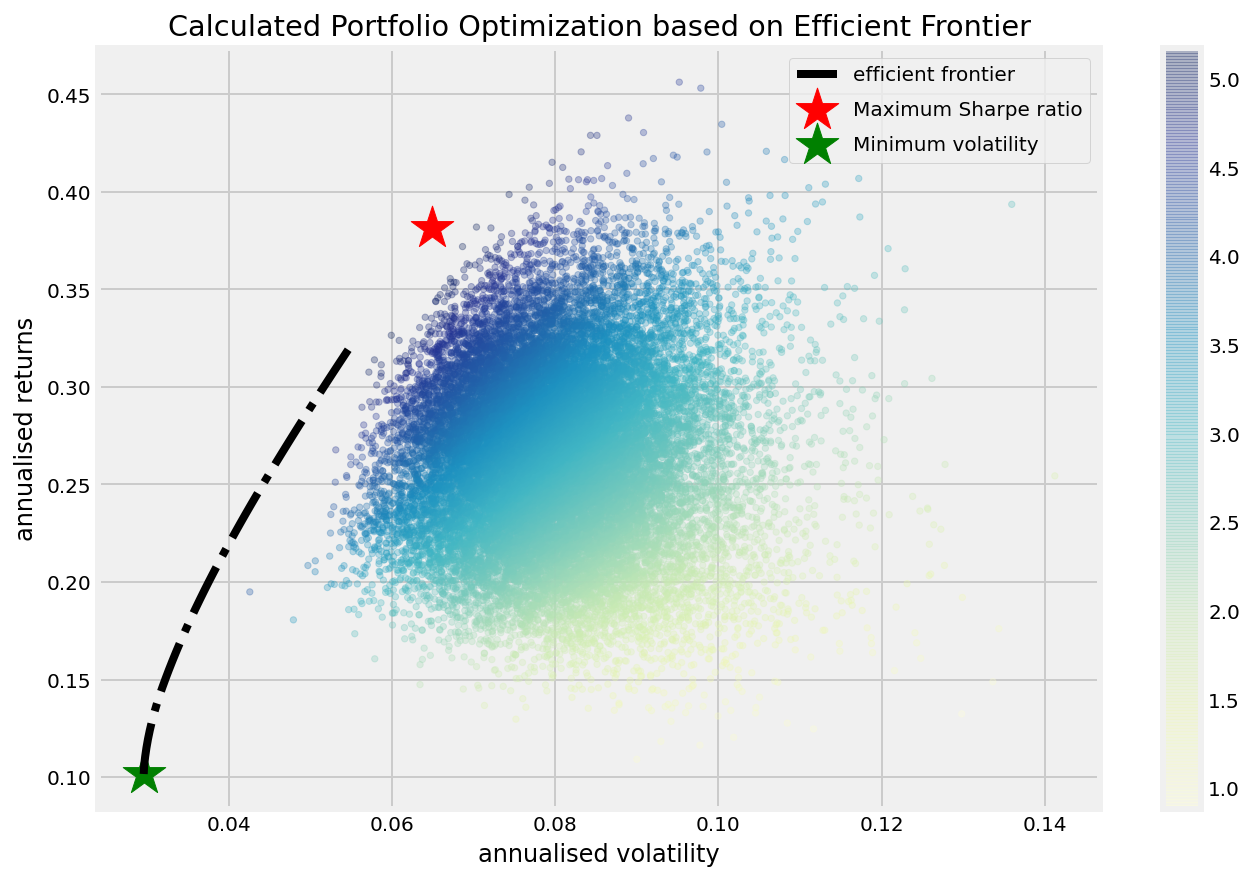

In [44]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [45]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.38
Annualised Volatility: 0.06


             BABA  BIDU  BMY    GLD   PG    SPY  TIP  TMF  VWO    WMT
allocation  21.44   0.0  0.0  32.72  0.0  32.37  0.0  0.0  0.0  13.47
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.03


            BABA  BIDU   BMY  GLD   PG    SPY    TIP  TMF  VWO   WMT
allocation   0.0  0.69  0.16  0.0  0.0  26.88  68.25  0.0  0.0  4.02
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

BABA : annuaised return 0.85 , annualised volatility: 0.19
BIDU : annuaised return 0.24 , annualised volatility: 0.2
BMY : annuaised return -0.1 , annualised volatility: 0.3
GLD : annuaised return 0.29 , annualised volatility: 0.1
PG : annuaised r

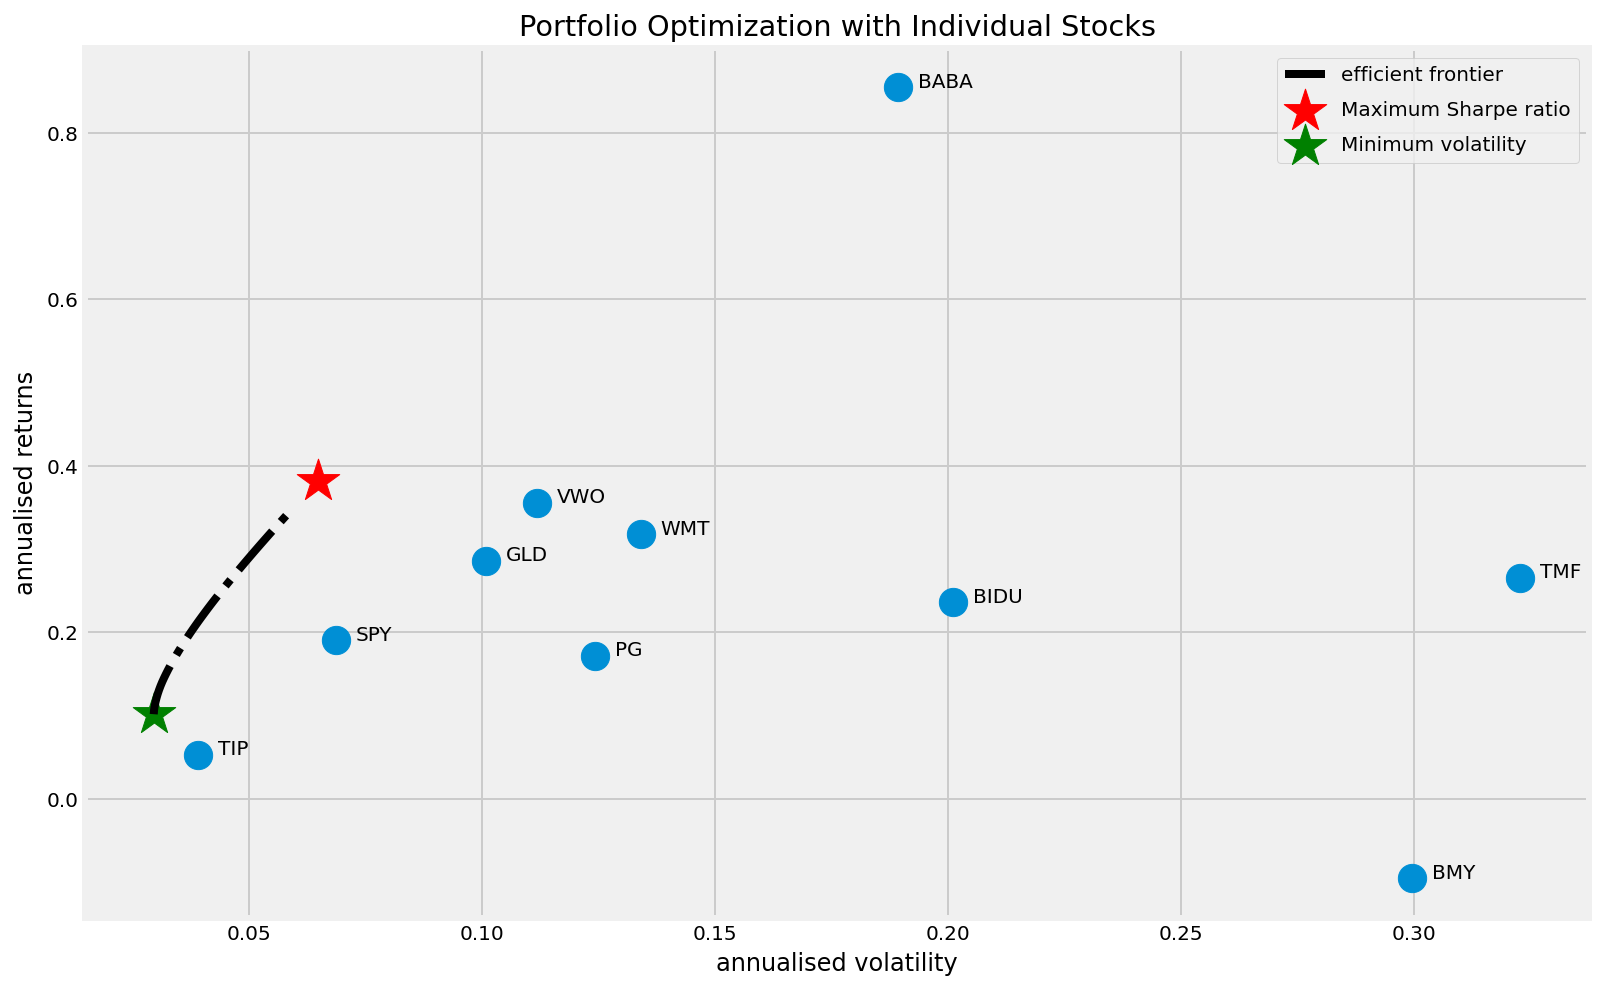

In [46]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)